In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


nifty_bank_tickers = [
    'HDFCBANK.NS', 'ICICIBANK.NS', 'SBIN.NS', 'KOTAKBANK.NS', 'AXISBANK.NS',
    'INDUSINDBK.NS', 'BANDHANBNK.NS', 'BANKBARODA.NS', 'FEDERALBNK.NS', 'PNB.NS'
]

data = yf.download(nifty_bank_tickers, start='2020-01-01', end='2024-06-13')['Adj Close']



[*********************100%***********************]  10 of 10 completed


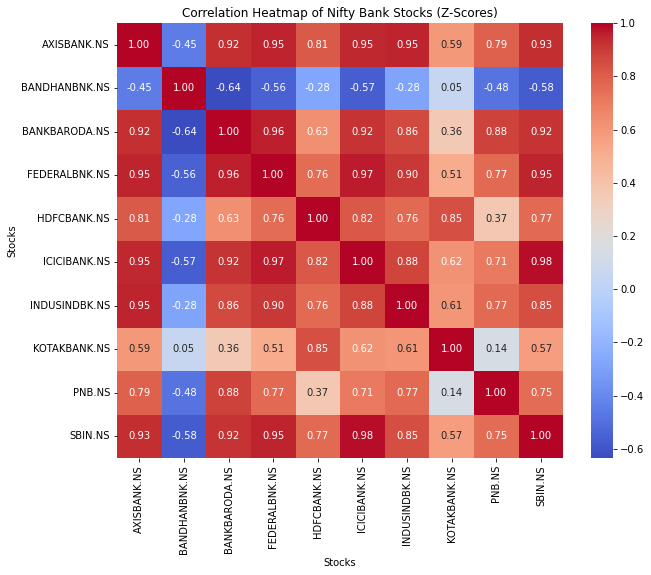

In [2]:
# Calculate z-scores for each stock
z_scores = (data - data.mean()) / data.std()

# Compute the correlation matrix
correlation_matrix = z_scores.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Nifty Bank Stocks (Z-Scores)')
plt.xlabel('Stocks')
plt.ylabel('Stocks')
plt.show()

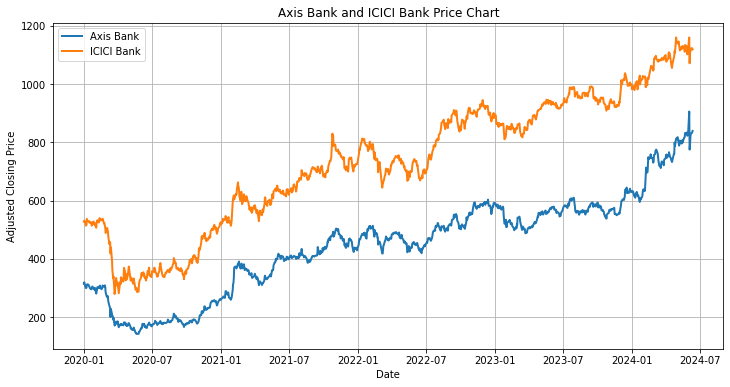

In [3]:
# Define the ticker symbols
tickers = ['SBI.NS', 'ICICIBANK.NS']

# Plot the price charts on the same axis
plt.figure(figsize=(12, 6))
plt.plot(data['SBIN.NS'], label='Axis Bank', linewidth=2)
plt.plot(data['ICICIBANK.NS'], label='ICICI Bank', linewidth=2)
plt.title('Axis Bank and ICICI Bank Price Chart')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price')
plt.legend()
plt.grid(True)
plt.show()


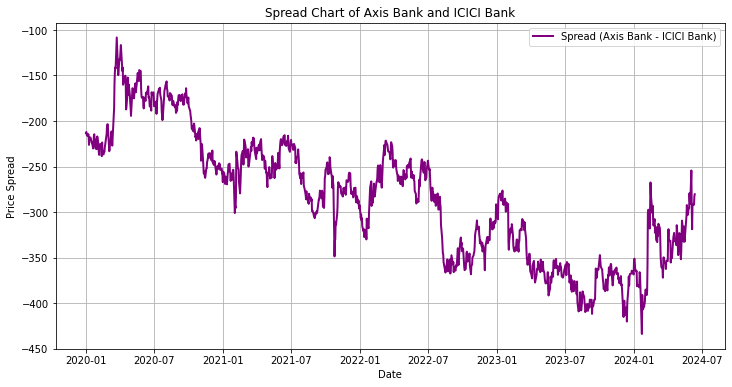

In [4]:
spread = data['SBIN.NS'] - data['ICICIBANK.NS']

# Plot the spread chart
plt.figure(figsize=(12, 6))
plt.plot(spread, label='Spread (Axis Bank - ICICI Bank)', color='purple', linewidth=2)
plt.title('Spread Chart of Axis Bank and ICICI Bank')
plt.xlabel('Date')
plt.ylabel('Price Spread')
plt.legend()
plt.grid(True)
plt.show()

                  SBIN    ICICIBANK      spread         z  z upper limit  \
Date                                                                       
2020-01-01  314.799225   527.647339 -212.848114  1.032135            1.0   
2020-01-02  319.364197   531.431946 -212.067749  1.043510            1.0   
2020-01-03  314.093262   529.711609 -215.618347  0.991755            1.0   
2024-06-10  831.799988  1123.800049 -292.000061 -0.121606            1.0   
2024-06-11  835.549988  1118.199951 -282.649963  0.014684            1.0   
2024-06-12  839.099976  1119.550049 -280.450073  0.046750            1.0   

            z lower limit  signals1  positions1  signals2  positions2  
Date                                                                   
2020-01-01           -1.0        -1         NaN         1         NaN  
2020-01-02           -1.0        -1         0.0         1         0.0  
2020-01-03           -1.0         0         1.0         0        -1.0  
2024-06-10           -1.0      

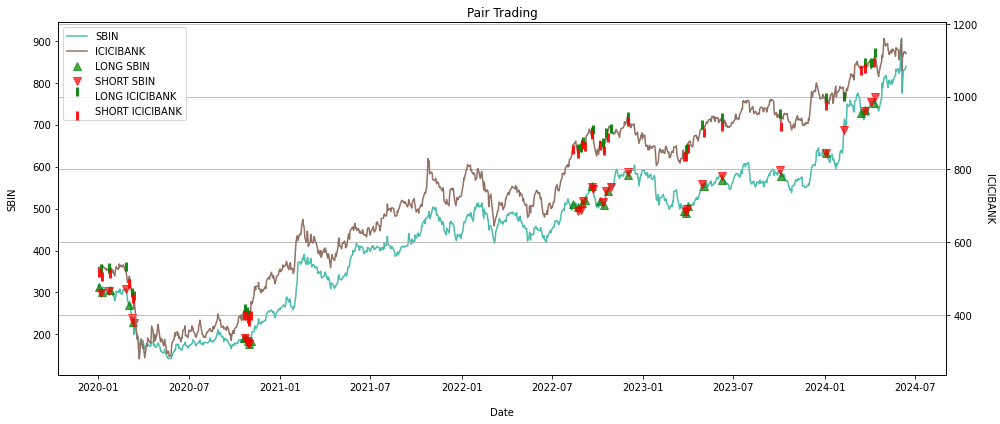

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# Function to calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

# Create a dataframe for trading signals
signals = pd.DataFrame()
signals['SBIN'] = data['SBIN.NS']
signals['ICICIBANK'] = data['ICICIBANK.NS']
signals['spread'] = spread

# Calculate the z-score of the spread
signals['z'] = zscore(signals['spread'])

# Define upper and lower thresholds for z-score
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

# Create trading signals
signals['signals1'] = 0
signals['signals1'] = np.select(
    [signals['z'] > signals['z upper limit'], signals['z'] < signals['z lower limit']],
    [-1, 1], 
    default=0
)

# Calculate positions
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

# Verify dataframe head and tail
print(signals.head(3).append(signals.tail(3)))

# Visualize trading signals and positions
fig = plt.figure(figsize=(14, 6))
bx = fig.add_subplot(111)
bx2 = bx.twinx()

# Plot two different assets
l1, = bx.plot(signals['SBIN'], c='#4abdac')
l2, = bx2.plot(signals['ICICIBANK'], c='#907163')
u1, = bx.plot(signals['SBIN'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g', alpha=0.7)
d1, = bx.plot(signals['SBIN'][signals['positions1'] == -1], lw=0, marker='v', markersize=8, c='r', alpha=0.7)
u2, = bx2.plot(signals['ICICIBANK'][signals['positions2'] == 1], lw=0, marker=2, markersize=9, c='g', alpha=0.9, markeredgewidth=3)
d2, = bx2.plot(signals['ICICIBANK'][signals['positions2'] == -1], lw=0, marker=3, markersize=9, c='r', alpha=0.9, markeredgewidth=3)

bx.set_ylabel('SBIN')
bx2.set_ylabel('ICICIBANK', rotation=270)
bx.yaxis.labelpad = 15
bx2.yaxis.labelpad = 15
bx.set_xlabel('Date')
bx.xaxis.labelpad = 15
plt.legend([l1, l2, u1, d1, u2, d2], 
           ['SBIN', 'ICICIBANK', 'LONG SBIN', 'SHORT SBIN', 'LONG ICICIBANK', 'SHORT ICICIBANK'], 
           loc='best')
plt.title('Pair Trading')
plt.xlabel('Date')
plt.grid(True)

plt.tight_layout()
plt.show()


Number of days = 1622
CAGR = 22.234%


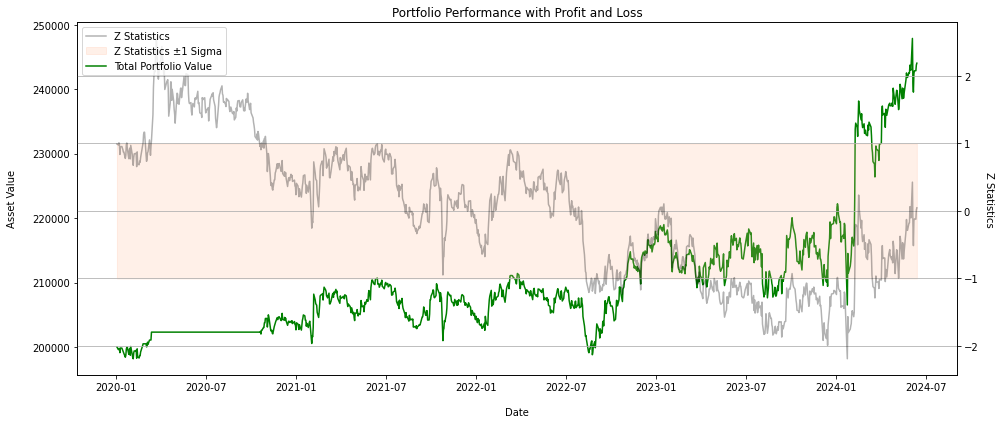

In [6]:
# Initial capital to calculate the actual PnL
initial_capital = 100000

# Shares to buy for each position
positions1 = initial_capital // max(signals['SBIN'])
positions2 = initial_capital // max(signals['ICICIBANK'])

# Create a dataframe for portfolio
portfolio = pd.DataFrame()
portfolio['SBIN'] = signals['SBIN']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['SBIN'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['SBIN'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

# PnL for the 2nd asset
portfolio['ICICIBANK'] = signals['ICICIBANK']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['ICICIBANK'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['ICICIBANK'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

# Total PnL and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

# Calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0]).days
print('Number of days =', delta)
YEAR_DAYS = 365
returns = (final_portfolio / initial_capital) ** (YEAR_DAYS / delta) - 1
print('CAGR = {:.3f}%'.format(returns * 100))

# Plot the asset value change of the portfolio and PnL along with z-score
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

# Plot total portfolio value and z-score
l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
b = ax2.fill_between(portfolio.index, portfolio['z upper limit'], portfolio['z lower limit'], alpha=0.2, color='#ffb48f')

ax.set_ylabel('Asset Value')
ax2.set_ylabel('Z Statistics', rotation=270)
ax.yaxis.labelpad = 15
ax2.yaxis.labelpad = 15
ax.set_xlabel('Date')
ax.xaxis.labelpad = 15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2, b, l1], ['Z Statistics', 'Z Statistics ±1 Sigma', 'Total Portfolio Value'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


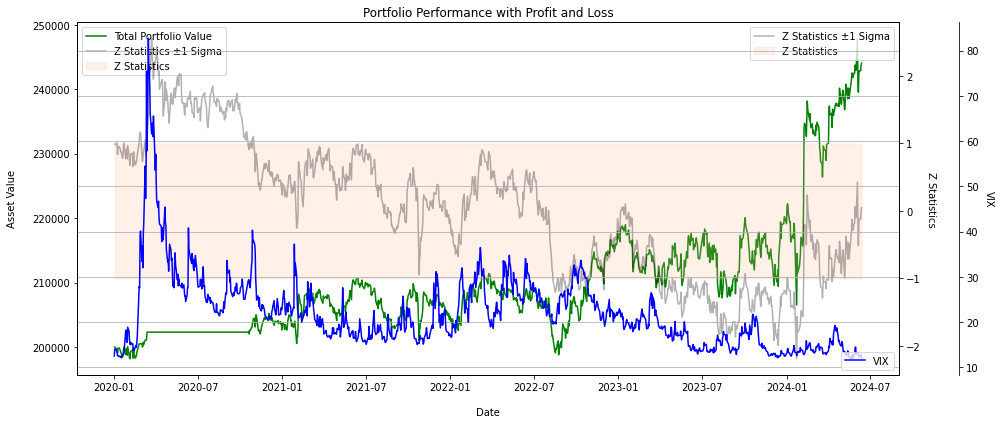

In [7]:
vix_data = yf.download('^VIX', start='2020-01-01', end='2024-06-13')['Adj Close']


portfolio = portfolio.dropna()

fig, ax = plt.subplots(figsize=(14, 6))
ax2 = ax.twinx()
ax3 = ax.twinx()

# Plot total portfolio value and z-score
l1, = ax.plot(portfolio['total asset'], c='g', label='Total Portfolio Value')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3, label='Z Statistics ±1 Sigma')
b = ax2.fill_between(portfolio.index, portfolio['z upper limit'], portfolio['z lower limit'],
                     alpha=0.2, color='#ffb48f', label='Z Statistics')

# Plot VIX
l3, = ax3.plot(vix_data, c='b', label='VIX')

# Set y-axis labels and legends
ax.set_ylabel('Asset Value')
ax2.set_ylabel('Z Statistics', rotation=270)
ax3.set_ylabel('VIX', rotation=270)
ax.yaxis.labelpad = 15
ax2.yaxis.labelpad = 15
ax3.yaxis.labelpad = 15
ax.set_xlabel('Date')
ax.xaxis.labelpad = 15
ax.legend([l1, l2, b], ['Total Portfolio Value', 'Z Statistics ±1 Sigma', 'Z Statistics'], loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='lower right')

# Align the right y-axis of ax3 with ax
ax3.spines['right'].set_position(('outward', 60))
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position('right')

plt.title('Portfolio Performance with Profit and Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
# Create a transaction history DataFrame
transactions = pd.DataFrame(columns=['Date', 'Stock', 'Action', 'Price', 'Shares'])

# Log transactions for Axis Bank
for i in range(1, len(signals)):
    if signals['positions1'].iloc[i] == 1:
        transactions = transactions.append({'Date': signals.index[i], 'Stock': 'SBIN', 'Action': 'Buy', 'Price': signals['SBIN'].iloc[i], 'Shares': positions1}, ignore_index=True)
    elif signals['positions1'].iloc[i] == -1:
        transactions = transactions.append({'Date': signals.index[i], 'Stock': 'SBIN', 'Action': 'Sell', 'Price': signals['SBIN'].iloc[i], 'Shares': positions1}, ignore_index=True)

# Log transactions for ICICI Bank
for i in range(1, len(signals)):
    if signals['positions2'].iloc[i] == 1:
        transactions = transactions.append({'Date': signals.index[i], 'Stock': 'ICICIBANK', 'Action': 'Buy', 'Price': signals['ICICIBANK'].iloc[i], 'Shares': positions2}, ignore_index=True)
    elif signals['positions2'].iloc[i] == -1:
        transactions = transactions.append({'Date': signals.index[i], 'Stock': 'ICICIBANK', 'Action': 'Sell', 'Price': signals['ICICIBANK'].iloc[i], 'Shares': positions2}, ignore_index=True)

# Print transaction history
print(transactions.to_string(index=False))

      Date     Stock Action       Price  Shares
2020-01-03      SBIN    Buy  314.093262   110.0
2020-01-07      SBIN   Sell  299.692169   110.0
2020-01-08      SBIN    Buy  301.009949   110.0
2020-01-23      SBIN   Sell  304.210205   110.0
2020-01-24      SBIN    Buy  305.010223   110.0
2020-02-25      SBIN   Sell  307.598633   110.0
2020-03-02      SBIN    Buy  270.513611   110.0
2020-03-09      SBIN   Sell  238.558365   110.0
2020-03-11      SBIN    Buy  230.699005   110.0
2020-03-13      SBIN   Sell  227.781128   110.0
2020-10-19      SBIN    Buy  192.013840   110.0
2020-10-22      SBIN   Sell  191.354980   110.0
2020-10-23      SBIN    Buy  190.884354   110.0
2020-10-26      SBIN   Sell  185.142761   110.0
2020-10-27      SBIN    Buy  183.213211   110.0
2020-10-28      SBIN   Sell  179.259979   110.0
2020-10-29      SBIN    Buy  177.612808   110.0
2020-10-30      SBIN   Sell  178.130493   110.0
2020-11-02      SBIN    Buy  184.530960   110.0
2022-08-12      SBIN    Buy  511.997742 

In [9]:
import pyfolio as pf

returns = portfolio['total asset'].pct_change().dropna()
pf.create_returns_tear_sheet(returns)

/Users/chrislernunes/opt/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


Start date,2020-01-06
End date,2024-06-12
Total months,52
,Backtest
Annual return,4.7%
Cumulative returns,22.0%
Annual volatility,8.7%
Sharpe ratio,0.57
Calmar ratio,0.66
Stability,0.64
Max drawdown,-7.1%


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'